In [1]:
try:
    spark.stop()
except:
    pass

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

spark = SparkSession.builder \
    .appName("APP_2") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)
])
# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, schema = schema).cache()

In [2]:
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

Rows: 32000204
Unique users: 200948
Unique Movies: 84432


In [3]:
# Select first n unique users
unique_users = df.select("userId").distinct().limit(1000)

# Keep only rows from these users
df = df.join(unique_users, on="userId", how="inner")

df.show(5)
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    28|      1|   4.0|
|    28|      2|   3.0|
|    28|      3|   4.0|
|    28|      5|   2.0|
|    28|      6|   3.0|
+------+-------+------+
only showing top 5 rows
Rows: 154972
Unique users: 1000
Unique Movies: 11459


In [4]:
n_users = df.select("userId").distinct().count()
n_movies = df.select("movieId").distinct().count()
n_ratings = df.count()

sparsity = (n_ratings / (n_users * n_movies)) * 100
print(f"Sparsity: {sparsity:.4f}%")

Sparsity: 1.3524%


In [5]:
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

user_indexer = StringIndexer(inputCol="userId", outputCol="user")
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")

pipeline = Pipeline(stages=[user_indexer, movie_indexer, assembler, scaler])

pipeline_model = pipeline.fit(df)
scaled_df = pipeline_model.transform(df)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final = df_final.cache()
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
| 0.0| 11.0|          0.8|
| 0.0|157.0|          0.6|
| 0.0|456.0|          0.8|
| 0.0|389.0|          0.3|
| 0.0|139.0|          0.6|
+----+-----+-------------+
only showing top 5 rows


In [6]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [7]:
import torch

# 80% train, 20% test
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

#Converting PySpark DF to Pandas to Tensors
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

X_train = torch.tensor(train_pd[["user", "movie"]].values)
y_train = torch.tensor(train_pd["rating_scaled"].values)

X_test = torch.tensor(test_pd[["user", "movie"]].values)
y_test = torch.tensor(test_pd["rating_scaled"].values)

print("Train count:", X_train.shape[0])
print("Train Label:",y_train.shape[0])
print("Test count:", X_test.shape[0])
print("Test Label:",y_test.shape[0])

Train count: 123827
Train Label: 123827
Test count: 31145
Test Label: 31145


In [8]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#print(train_dataset[2200])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  
        self.dropout_emb = 0.4

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),  
            nn.ReLU()  
        )

    def forward(self,user,movie):
        u = F.dropout(self.user_emb(user), p=self.dropout_emb, training=self.training)
        m = F.dropout(self.movie_emb(movie), p=self.dropout_emb, training=self.training)
        
        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)
        
        # Pass through MLP
        return self.mlp(x).squeeze()


In [10]:
loss_fn = nn.MSELoss()

In [11]:
def adam(parameter, m_state, v_state, t, lr=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state



================ RUN 1/5 ================

--- Training Node 1 on Split 1 ---
Node 1 | Epoch 1/2 | Train Loss: 0.0506, Train RMSE: 0.2249 | Test Loss: 0.0446, Test RMSE: 0.2111
Node 1 | Epoch 2/2 | Train Loss: 0.0450, Train RMSE: 0.2120 | Test Loss: 0.0464, Test RMSE: 0.2153

--- Training Node 2 on Split 2 ---
Node 2 | Epoch 1/2 | Train Loss: 0.0498, Train RMSE: 0.2231 | Test Loss: 0.0489, Test RMSE: 0.2211
Node 2 | Epoch 2/2 | Train Loss: 0.0447, Train RMSE: 0.2115 | Test Loss: 0.0417, Test RMSE: 0.2041

--- Training Node 3 on Split 3 ---
Node 3 | Epoch 1/2 | Train Loss: 0.0504, Train RMSE: 0.2245 | Test Loss: 0.0433, Test RMSE: 0.2079
Node 3 | Epoch 2/2 | Train Loss: 0.0448, Train RMSE: 0.2117 | Test Loss: 0.0408, Test RMSE: 0.2020

--- Training Node 4 on Split 4 ---
Node 4 | Epoch 1/2 | Train Loss: 0.0519, Train RMSE: 0.2277 | Test Loss: 0.0457, Test RMSE: 0.2138
Node 4 | Epoch 2/2 | Train Loss: 0.0463, Train RMSE: 0.2152 | Test Loss: 0.0454, Test RMSE: 0.2131

--- Training Node 5 

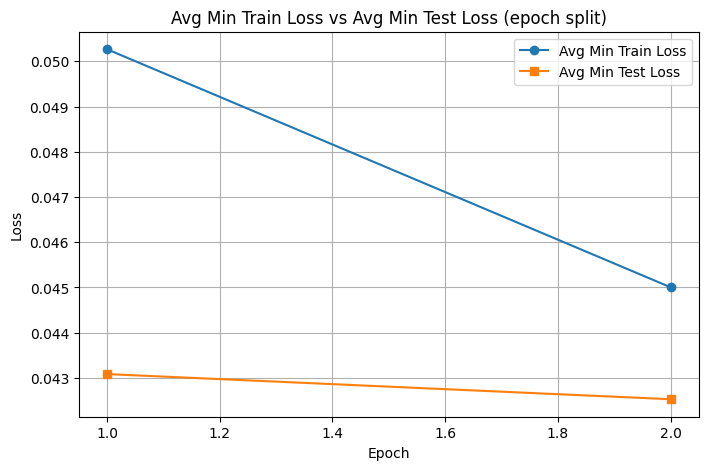

In [15]:
import copy
import matplotlib.pyplot as plt
import numpy as np

# ---------- Settings ----------
epochs = 2
n_nodes = 5
n_runs = 5   # number of experiments

all_runs_min_train = []
all_runs_min_test_loss = []   # <-- NEW (test loss instead of RMSE)

all_runs_min_avg_train = []
all_runs_min_avg_test = []

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

for run in range(1, n_runs + 1):
    print(f"\n================ RUN {run}/{n_runs} ================")

    all_nodes_stats = []         
    min_train_curve = []         
    min_test_loss_curve = []     # <-- NEW

    avg_train_curve = []         
    avg_test_curve = []          

    # ---------- Train nodes ----------
    for node_id in range(1, n_nodes + 1):
        print(f"\n--- Training Node {node_id} on Split {node_id} ---")
        node_model = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)

        train_losses_epoch, test_losses_epoch = [], []
        train_rmses_epoch, test_rmses_epoch = [], []
        epoch_states = []

        # Adam states
        m_state, v_state, t = {}, {}, 0

        for epoch in range(epochs):
            # ---------- Training ----------
            node_model.train()
            total_loss, total_sq_error, total_samples = 0, 0, 0
            for X_batch, y_batch in train_loader:
                preds = node_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                node_model.zero_grad()
                loss.backward()
                t += 1
                m_state, v_state = adam(node_model.parameters(), m_state, v_state, t)

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch)**2).item()
                total_samples += len(y_batch)

            train_loss = total_loss / len(train_loader)
            train_rmse = (total_sq_error / total_samples) ** 0.5

            # ---------- Testing ----------
            node_model.eval()
            total_loss, total_sq_error, total_samples = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    preds = node_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                    loss = loss_fn(preds, y_batch.float())
                    total_loss += loss.item()
                    total_sq_error += torch.sum((preds - y_batch)**2).item()
                    total_samples += len(y_batch)

            test_loss = total_loss / len(test_loader)
            test_rmse = (total_sq_error / total_samples) ** 0.5

            # ---------- Save Stats ----------
            train_losses_epoch.append(train_loss)
            test_losses_epoch.append(test_loss)
            train_rmses_epoch.append(train_rmse)
            test_rmses_epoch.append(test_rmse)
            epoch_states.append(copy.deepcopy(node_model.state_dict()))

            print(f"Node {node_id} | Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
                  f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---------- Save node stats ----------
        all_nodes_stats.append({
            "node": node_id,
            "train_losses": train_losses_epoch,
            "test_losses": test_losses_epoch,
            "train_rmses": train_rmses_epoch,
            "test_rmses": test_rmses_epoch,
            "epoch_states": epoch_states
        })

    # ---------- Aggregation (per epoch) ----------
    for epoch in range(epochs):
        # min across nodes
        min_train_curve.append(min(node["train_losses"][epoch] for node in all_nodes_stats))
        min_test_loss_curve.append(min(node["test_losses"][epoch] for node in all_nodes_stats))  # <-- test loss

        # avg across nodes
        avg_train_curve.append(np.mean([node["train_losses"][epoch] for node in all_nodes_stats]))
        avg_test_curve.append(np.mean([node["test_losses"][epoch] for node in all_nodes_stats]))

    # Save run results
    all_runs_min_train.append(min_train_curve)
    all_runs_min_test_loss.append(min_test_loss_curve)   # <-- save test loss minima

    # Save min of avg curves for this run
    all_runs_min_avg_train.append(min(avg_train_curve))
    all_runs_min_avg_test.append(min(avg_test_curve))


# ---------- Average over Runs (epoch-wise) ----------
avg_min_train_loss = np.mean(all_runs_min_train, axis=0)
avg_min_test_loss = np.mean(all_runs_min_test_loss, axis=0)  # <-- NEW

# ---------- Plot ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), avg_min_train_loss, marker='o', label="Avg Min Train Loss")
plt.plot(range(1, epochs+1), avg_min_test_loss, marker='s', label="Avg Min Test Loss")  # <-- plot test loss instead of RMSE
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Avg Min Train Loss vs Avg Min Test Loss (epoch split)")
plt.legend()
plt.grid(True)
plt.show()


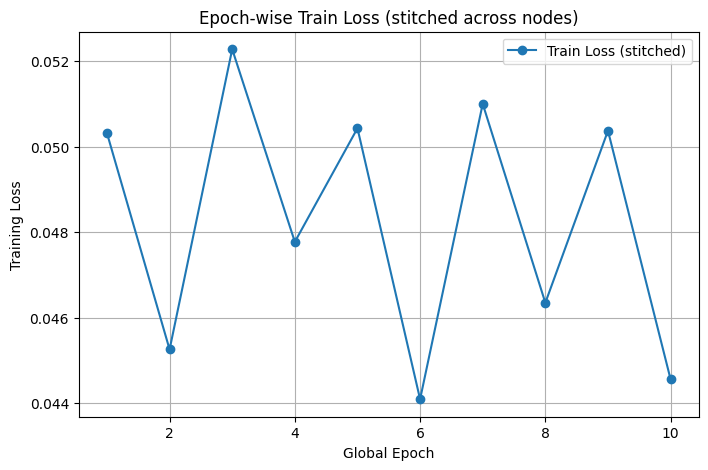

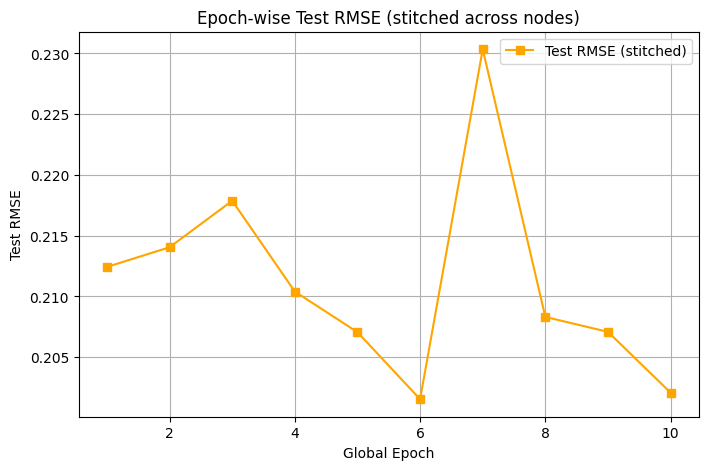

In [17]:
# ---------- Aggregation (Epoch Split: stitch node curves sequentially) ----------
stitched_train_curve = []
stitched_test_rmse_curve = []

epochs_per_node = 2   # each node runs 2 epochs

for node in all_nodes_stats:
    # take only the first `epochs_per_node` values from each node
    for e in range(epochs_per_node):
        stitched_train_curve.append(node["train_losses"][e])
        stitched_test_rmse_curve.append(node["test_rmses"][e])

# ---------- Plot Stitched Train Loss ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(stitched_train_curve)+1), stitched_train_curve, marker='o', label="Train Loss (stitched)")
plt.xlabel("Global Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch-wise Train Loss (stitched across nodes)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Plot Stitched Test RMSE ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(stitched_test_rmse_curve)+1), stitched_test_rmse_curve, marker='s', color='orange', label="Test RMSE (stitched)")
plt.xlabel("Global Epoch")
plt.ylabel("Test RMSE")
plt.title("Epoch-wise Test RMSE (stitched across nodes)")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import utils

metrics = {
    "min_train_curve": min_train_curve,
    "min_test_loss_curve": min_test_loss_curve,
    "stitched_test_rmse_curve": stitched_test_rmse_curve,
    "stitched_train_curve": stitched_train_curve,
    "avg_min_train_loss": avg_min_train_loss,
    "avg_min_test_loss": avg_min_test_loss
}

# Save the Base approach results
utils.save_results("results/epoch_split.pkl", metrics)


In [13]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------- Settings ----------
epochs_stage1 = 2
n_nodes = 5

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

all_nodes_stats = []

print("\n================ STAGE 1: NODE TRAINING ================")
for node_id in range(1, n_nodes + 1):
    print(f"\n--- Training Node {node_id} ---")
    node_model = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)

    train_losses_epoch, test_losses_epoch = [], []
    epoch_states = []

    # Adam states
    m_state, v_state, t = {}, {}, 0

    for epoch in range(epochs_stage1):
        # Training
        node_model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            preds = node_model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            node_model.zero_grad()
            loss.backward()
            t += 1
            m_state, v_state = adam(node_model.parameters(), m_state, v_state, t)
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # Testing
        node_model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = node_model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()

        test_loss = total_loss / len(test_loader)

        # Save stats
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        epoch_states.append(copy.deepcopy(node_model.state_dict()))

        print(f"Node {node_id} | Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    # Save node info
    all_nodes_stats.append({
        "node": node_id,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "epoch_states": epoch_states
    })



================ STAGE 1: NODE TRAINING ================

--- Training Node 1 ---
Node 1 | Epoch 1 | Train Loss: 0.1046 | Test Loss: 0.0827
Node 1 | Epoch 2 | Train Loss: 0.1064 | Test Loss: 0.0808

--- Training Node 2 ---
Node 2 | Epoch 1 | Train Loss: 0.0981 | Test Loss: 0.0885
Node 2 | Epoch 2 | Train Loss: 0.1070 | Test Loss: 0.0908

--- Training Node 3 ---
Node 3 | Epoch 1 | Train Loss: 0.1048 | Test Loss: 0.0930
Node 3 | Epoch 2 | Train Loss: 0.1064 | Test Loss: 0.0940

--- Training Node 4 ---
Node 4 | Epoch 1 | Train Loss: 0.1070 | Test Loss: 0.0973
Node 4 | Epoch 2 | Train Loss: 0.1087 | Test Loss: 0.0968

--- Training Node 5 ---
Node 5 | Epoch 1 | Train Loss: 0.1066 | Test Loss: 0.0955
Node 5 | Epoch 2 | Train Loss: 0.1003 | Test Loss: 0.0822


In [16]:
import numpy as np
import copy
import torch

def aggregate_models_cpu(weights, node_states):
    agg_state = {}
    with torch.no_grad():
        for key in node_states[0].keys():
            agg_param = torch.zeros_like(node_states[0][key])
            for i in range(len(node_states)):
                agg_param += weights[i] * node_states[i][key]
            agg_state[key] = agg_param
    return agg_state

def evaluate_model_cpu(global_state, model_template, test_loader, loss_fn):
    model = copy.deepcopy(model_template)
    model.load_state_dict(global_state)
    model.eval()
    total_loss, total_samples = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            total_loss += loss.item()
            total_samples += 1
    return total_loss / total_samples

def pso_aggregate_cpu(all_nodes_stats, model_template, test_loader, loss_fn,
                      num_particles=10, max_iters=20, w=0.7, c1=1.5, c2=1.5):
    num_nodes = len(all_nodes_stats)
    node_states = [node["epoch_states"][-1] for node in all_nodes_stats]

    # Initialize particles and velocities
    particles = np.random.dirichlet(np.ones(num_nodes), size=num_particles)
    velocities = np.zeros_like(particles)
    pbest_positions = np.copy(particles)
    pbest_scores = np.full(num_particles, np.inf)

    gbest_position = None
    gbest_score = np.inf

    print("\n🚀 Starting CPU PSO Aggregation Optimization...")
    for iter_ in range(max_iters):
        for i in range(num_particles):
            weights = np.abs(particles[i])
            weights /= np.sum(weights)

            # Aggregate and evaluate
            global_state = aggregate_models_cpu(weights, node_states)
            test_loss = evaluate_model_cpu(global_state, model_template, test_loader, loss_fn)

            # Update personal best
            if test_loss < pbest_scores[i]:
                pbest_scores[i] = test_loss
                pbest_positions[i] = weights.copy()

            # Update global best
            if test_loss < gbest_score:
                gbest_score = test_loss
                gbest_position = weights.copy()

        # Update velocities & positions
        for i in range(num_particles):
            r1, r2 = np.random.rand(num_nodes), np.random.rand(num_nodes)
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (pbest_positions[i] - particles[i])
                + c2 * r2 * (gbest_position - particles[i])
            )
            particles[i] += velocities[i]

        if (iter_ + 1) % 5 == 0 or iter_ == 0:
            print(f"Iteration {iter_+1}/{max_iters} | Best Test Loss: {gbest_score:.4f}")

    # Final aggregation using the best weights
    final_state = aggregate_models_cpu(gbest_position, node_states)
    final_loss = evaluate_model_cpu(final_state, model_template, test_loader, loss_fn)

    print("\n✅ CPU PSO Aggregation Completed!")
    print(f"🌍 Global Best Test Loss: {gbest_score:.4f}, Final Loss: {final_loss:.4f}")
    print(f"🔹 Optimal Weights per Node: {np.round(gbest_position, 4)}")

    return final_state, gbest_position, gbest_score


In [18]:
# ---------- Stage 2: PSO Aggregation ----------

print("\n================ STAGE 2: PSO AGGREGATION =================")

# Initialize a fresh model template
model_template = CollabFiltering(
    n_users_global, 
    n_movies_global, 
    emb_dim=16, 
    hidden=16, 
    dropout=0.1
)

# Pick a test loader to evaluate aggregated models (for simplicity, use node 1)
global_test_loader = test_loader  # or all_loaders[0]["test_loader"] if using multiple loaders

# Run PSO aggregation
global_state, best_weights, best_loss= pso_aggregate_cpu(
    all_nodes_stats,       # Stage 1 node info with 'epoch_states'
    model_template,        # Template model to load aggregated weights
    global_test_loader,    # Test data loader
    loss_fn,               # Loss function (e.g., nn.MSELoss())
    num_particles=10,      # PSO particles
    max_iters=20           # PSO iterations
)

# global_state now contains the aggregated model
# best_weights contains the optimal weights per node



================ STAGE 2: PSO AGGREGATION =================

🚀 Starting CPU PSO Aggregation Optimization...
Iteration 1/20 | Best Test Loss: 0.0690
Iteration 5/20 | Best Test Loss: 0.0594
Iteration 10/20 | Best Test Loss: 0.0592
Iteration 15/20 | Best Test Loss: 0.0591
Iteration 20/20 | Best Test Loss: 0.0590

✅ CPU PSO Aggregation Completed!
🌍 Global Best Test Loss: 0.0590, Final Loss: 0.0590
🔹 Optimal Weights per Node: [0.1731 0.2124 0.177  0.1691 0.2683]


In [20]:
import copy
import torch
import numpy as np

# ---------- Settings ----------
epochs_stage2 = 2 # number of continuation epochs
n_nodes = 5
lr_stage2 = 0.01

stage2_stats = []

print("\n================ STAGE 2: NODE CONTINUATION TRAINING ================")
for node_id, node_data in enumerate(all_nodes_stats, start=1):
    print(f"\n--- Stage 2: Node {node_id} continuation ---")

    n_users = node_data["epoch_states"][0]['user_emb.weight'].shape[0]
    n_movies = node_data["epoch_states"][0]['movie_emb.weight'].shape[0]

    # Initialize node with PSO-aggregated global weights
    node_model = CollabFiltering(n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1)
    node_model.load_state_dict(global_state)

    optimizer = torch.optim.Adam(node_model.parameters(), lr=lr_stage2)

    train_losses_epoch, test_losses_epoch = [], []
    epoch_states = []

    for epoch in range(epochs_stage2):
        # ---------- Training ----------
        node_model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            preds = node_model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            node_model.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # ---------- Testing ----------
        node_model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = node_model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()

        test_loss = total_loss / len(test_loader)

        # ---------- Save stats ----------
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        epoch_states.append(copy.deepcopy(node_model.state_dict()))

        print(f"Node {node_id} | Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    # ---------- Save node info ----------
    stage2_stats.append({
        "node": node_id,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "epoch_states": epoch_states
    })



================ STAGE 2: NODE CONTINUATION TRAINING ================

--- Stage 2: Node 1 continuation ---
Node 1 | Epoch 1 | Train Loss: 0.0605 | Test Loss: 0.0576
Node 1 | Epoch 2 | Train Loss: 0.0575 | Test Loss: 0.0569

--- Stage 2: Node 2 continuation ---
Node 2 | Epoch 1 | Train Loss: 0.0606 | Test Loss: 0.0574
Node 2 | Epoch 2 | Train Loss: 0.0578 | Test Loss: 0.0568

--- Stage 2: Node 3 continuation ---
Node 3 | Epoch 1 | Train Loss: 0.0603 | Test Loss: 0.0577
Node 3 | Epoch 2 | Train Loss: 0.0573 | Test Loss: 0.0569

--- Stage 2: Node 4 continuation ---
Node 4 | Epoch 1 | Train Loss: 0.0605 | Test Loss: 0.0570
Node 4 | Epoch 2 | Train Loss: 0.0576 | Test Loss: 0.0575

--- Stage 2: Node 5 continuation ---
Node 5 | Epoch 1 | Train Loss: 0.0608 | Test Loss: 0.0574
Node 5 | Epoch 2 | Train Loss: 0.0579 | Test Loss: 0.0569
